


---

# Install Libraries and Import Data



---



This section ensures all necessary libraries are installed and imported to facilitate data analysis, visualization, and machine learning tasks. Libraries like `xgboost` and `scikit-learn` are essential for model building and evaluation, while `pandas` and `numpy` handle data manipulation. Visualization libraries like `matplotlib` and `seaborn` are included to generate insightful plots. Additionally, helper functions from `scikit-learn` like `train_test_split` and evaluation metrics such as `accuracy_score` and `classification_report` are imported to support the machine learning pipeline.


In [2]:
# Install necessary libraries
!pip install xgboost scikit-learn matplotlib pandas seaborn

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,
    confusion_matrix, classification_report
)
from xgboost import XGBClassifier, DMatrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV






---

# Feature Engineering


---



Feature engineering involves transforming raw data into meaningful features that enhance the predictive performance of machine learning models. This section performs the following steps:

1. **Title Extraction and Grouping**: Extracts titles from the 'Name' column to capture information about passengers' social status or roles. Rare titles are grouped under 'Rare', and similar titles are standardized (e.g., 'Mlle' and 'Ms' become 'Miss').
2. **Family Features**: Creates 'FamilySize' by combining 'SibSp' and 'Parch', adding 1 to include the individual passenger. Additionally, the 'IsAlone' feature is introduced to indicate whether a passenger is traveling alone.
3. **Missing Value Imputation**: Fills missing values in 'Age' and 'Fare' using their respective medians and replaces missing 'Embarked' values with the mode.
4. **Irrelevant Column Removal**: Drops unnecessary columns ('Name', 'Ticket', 'Cabin') to streamline the dataset for modeling.


In [3]:
# Feature Engineering function
def feature_engineering(df):
    # Extract titles from 'Name'
    df = df.copy()
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # Group rare titles
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # Family size and IsAlone
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Fill missing values
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Drop irrelevant columns
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])

    return df

# Load datasets and apply feature engineering
train_data = pd.read_csv('/content/train.csv')
train_data = feature_engineering(train_data)



---

# Basic Statistical Analysis


---



Basic statistical analysis provides an overview of the data and highlights key characteristics, helping to understand the dataset's structure and any potential anomalies. This step typically includes:

1. **Descriptive Statistics**: Calculating measures like mean, median, standard deviation, and range for numerical features.
2. **Distribution Analysis**: Checking the distribution of data through visualizations or summary statistics to identify skewness, outliers, or unusual patterns.
3. **Categorical Feature Exploration**: Examining the frequency and distribution of categorical features to understand their contribution and balance within the dataset.

This analysis aids in making informed decisions during feature engineering and model building.

Numeric Feature Summary:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  FamilySize     IsAlone  
count  891.000000  891.000000  891.000000  891.000000  
mean     0.381594   32.204208    1.904602    0.602694  
std      0.806057   49.693429    1.613459    0.489615  
min      0.000000    0.000000    1.000000    0.000000  
25%      0.000000    7.910400    1.000000    0.000000  
50%     

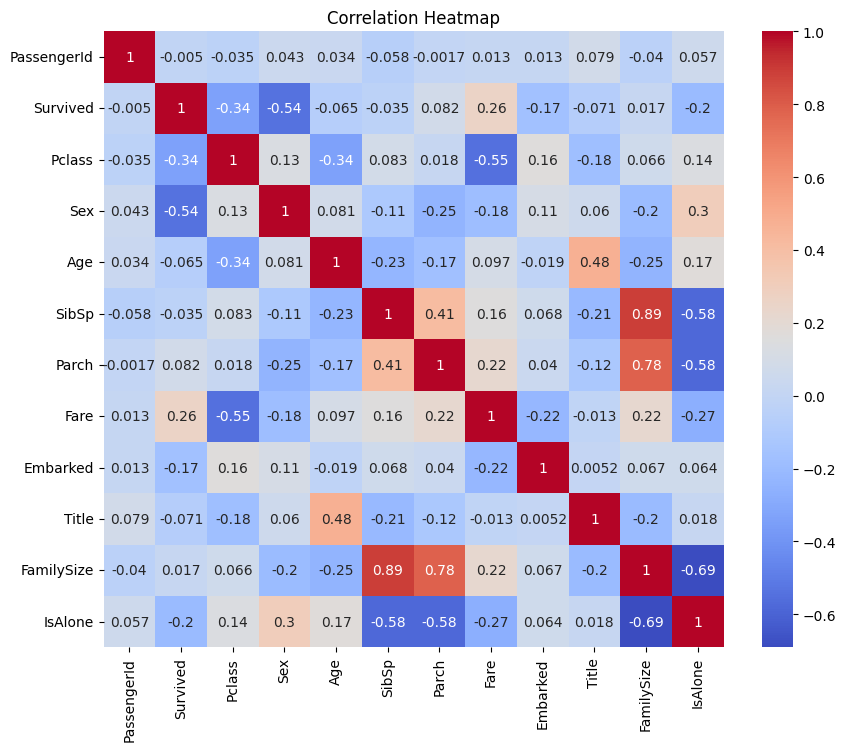


Visualizing Numeric Feature Distributions:


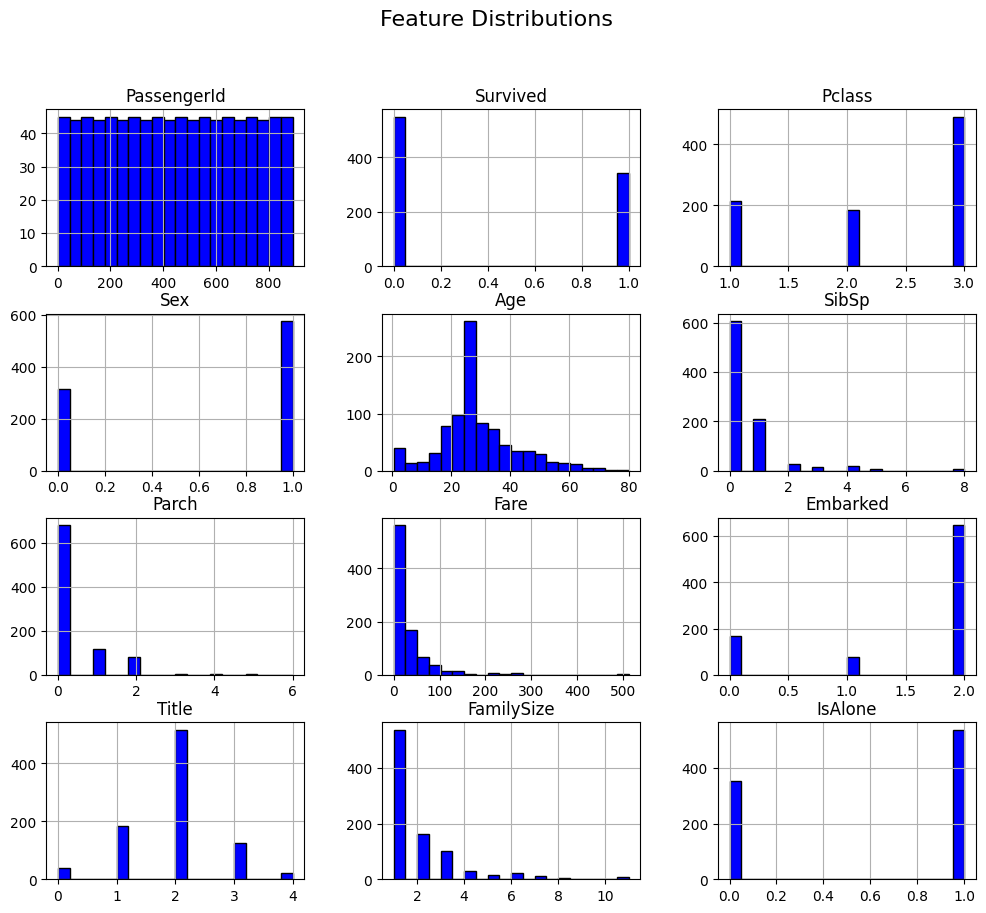


Target Variable Distribution:
Survived
0    549
1    342
Name: count, dtype: int64


<ipython-input-4-572c7375bc0f>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


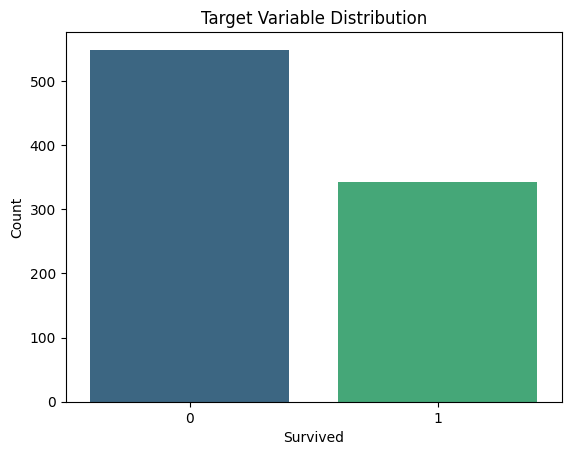

In [4]:
# Basic statistical analysis
def basic_statistical_analysis(data):
    # 1. Summary statistics for numeric features
    print("Numeric Feature Summary:")
    print(data.describe())

    # 2. Missing values summary
    print("\nMissing Values Summary:")
    missing_values = data.isnull().sum()
    if missing_values.sum() == 0:
        print("No missing values in the dataset.")
    else:
        print(missing_values[missing_values > 0])

    # 3. Categorical feature value counts
    print("\nCategorical Feature Value Counts:")
    categorical_columns = data.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        print(f"Value Counts for {column}:")
        print(data[column].value_counts())
        print("\n")

    # 4. Correlation matrix for numeric features
    print("\nCorrelation Matrix:")

    # Encode categorical columns before correlation computation
    label_enc = LabelEncoder()
    for column in categorical_columns:
        data[column] = label_enc.fit_transform(data[column])

    correlation_matrix = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

    # 5. Distributions of numeric features
    print("\nVisualizing Numeric Feature Distributions:")
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    data[numeric_columns].hist(figsize=(12, 10), bins=20, color='blue', edgecolor='black')
    plt.suptitle("Feature Distributions", size=16)
    plt.show()

    # 6. Target variable analysis
    if 'Survived' in data.columns:
        print("\nTarget Variable Distribution:")
        target_counts = data['Survived'].value_counts()
        print(target_counts)

        # Plot the target variable distribution
        sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
        plt.xlabel("Survived")
        plt.ylabel("Count")
        plt.title("Target Variable Distribution")
        plt.show()
    else:
        print("\nTarget variable ('Survived') not found in the dataset.")

# Call the function
basic_statistical_analysis(train_data)



---

# Split Data Into Train - Test Split


---



This section is crucial for evaluating the performance of machine learning models. The dataset is divided into training and testing subsets to ensure that the model generalizes well to unseen data. Here are the steps involved:

1. **Define Features and Target**: The independent variables (`X`) and the target variable (`y`) are separated. `X` contains all features that will be used for prediction, while `y` contains the output labels.
2. **Split the Data**: The data is split into training and testing subsets using `train_test_split`. Typically, 80% of the data is used for training, and 20% is reserved for testing.
3. **Random State for Reproducibility**: A fixed random state ensures the split is reproducible, making results consistent across different runs.

This approach helps in assessing how well the model performs on data it hasn't seen before, thereby preventing overfitting.

In [5]:
# Separate features and target variable
X = train_data.drop(columns=['PassengerId', 'Survived'])
y = train_data['Survived']

# Split the data into Train (70%) and Test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Identify categorical columns for encoding
categorical_columns = ['Embarked', 'Title', 'Sex']

# Apply Label Encoding to categorical columns
label_enc = LabelEncoder()
for column in categorical_columns:
    X_train[column] = label_enc.fit_transform(X_train[column])
    X_test[column] = label_enc.transform(X_test[column])

# Ensure all columns are converted to float for compatibility with XGBoost
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Verify the shape of the training and testing data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f'_'*30)
print(f"y_train distribution:\n{y_train.value_counts()}")
print(f'_'*30)
print(f"y_test distribution:\n{y_test.value_counts()}")

X_train shape: (623, 10)
X_test shape: (268, 10)
______________________________
y_train distribution:
Survived
0    384
1    239
Name: count, dtype: int64
______________________________
y_test distribution:
Survived
0    165
1    103
Name: count, dtype: int64




---

# Handle Imbalanced Data


---



 Categorical columns such as 'Embarked', 'Title', and 'Sex' are transformed into numerical values using LabelEncoder. Columns containing numerical data like 'FamilySize' are converted to the correct data type (int). The distribution of the classes in the data is then analyzed using Counter, and the scale_pos_weight for XGBoost is calculated to balance the imbalanced classes. Class weights are computed using compute_class_weight to assist models like RandomForest and LogisticRegression. Finally, a bar chart is displayed to compare the class distribution before and after adjusting the class weights.

Class Distribution in y_train:
Counter({0: 384, 1: 239})
____________________________________________________________
Scale Pos Weight (for XGBoost): 1.61
____________________________________________________________
Class Weights:
 {0: 0.8111979166666666, 1: 1.3033472803347281}
____________________________________________________________
X_train dtypes after encoding and conversion:

Pclass        float64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked        int64
Title           int64
FamilySize      int64
IsAlone       float64
dtype: object


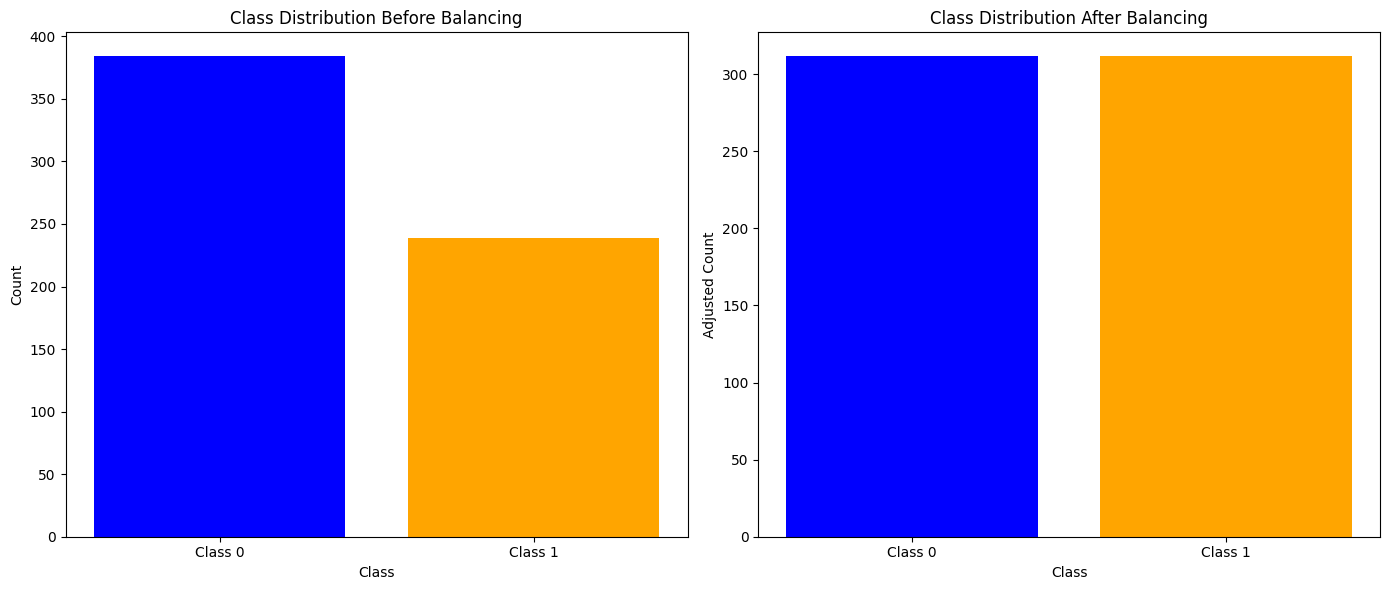

In [6]:
# Identify categorical columns
categorical_columns = ['Embarked', 'Title', 'Sex']

# Apply Label Encoding to categorical columns
label_enc = LabelEncoder()
for column in categorical_columns:
    X_train[column] = label_enc.fit_transform(X_train[column])
    X_test[column] = label_enc.transform(X_test[column])

# Convert columns that contain counts to integer type
columns_to_int = ['FamilySize', 'SibSp', 'Parch']
for column in columns_to_int:
    X_train[column] = X_train[column].astype(int)
    X_test[column] = X_test[column].astype(int)

# Check class distribution
print("Class Distribution in y_train:")
class_counts = Counter(y_train)
print(class_counts)
print(f'_'*60)

# Compute scale_pos_weight for XGBoost
negative_class = class_counts[0]  # Count of class 0
positive_class = class_counts[1]  # Count of class 1
scale_pos_weight = negative_class / positive_class
print(f"Scale Pos Weight (for XGBoost): {scale_pos_weight:.2f}")
print(f'_'*60)

# Compute class weights for models like RandomForest or LogisticRegression
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:\n", class_weight_dict)
print(f'_'*60)

# Verify data types
print("X_train dtypes after encoding and conversion:\n")
print(X_train.dtypes)

# Visualization: Class distribution before and after balancing
balanced_class_counts = {0: class_weights[0] * class_counts[0], 1: class_weights[1] * class_counts[1]}

# Plot the class distribution before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Class distribution before balancing
axes[0].bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].set_xticks(list(class_counts.keys()))
axes[0].set_xticklabels(["Class 0", "Class 1"])

# Class distribution after balancing (using class weights)
axes[1].bar(balanced_class_counts.keys(), balanced_class_counts.values(), color=['blue', 'orange'])
axes[1].set_title("Class Distribution After Balancing")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Adjusted Count")
axes[1].set_xticks(list(balanced_class_counts.keys()))
axes[1].set_xticklabels(["Class 0", "Class 1"])

plt.tight_layout()
plt.show()



---

# Train, evaluate model and Plot ROC Curves


---



The XGBoost model is trained on the training data and evaluated using metrics like accuracy, precision, recall, and F1-score. An ROC curve is plotted to calculate the AUC, assessing the model's ability to distinguish between classes.

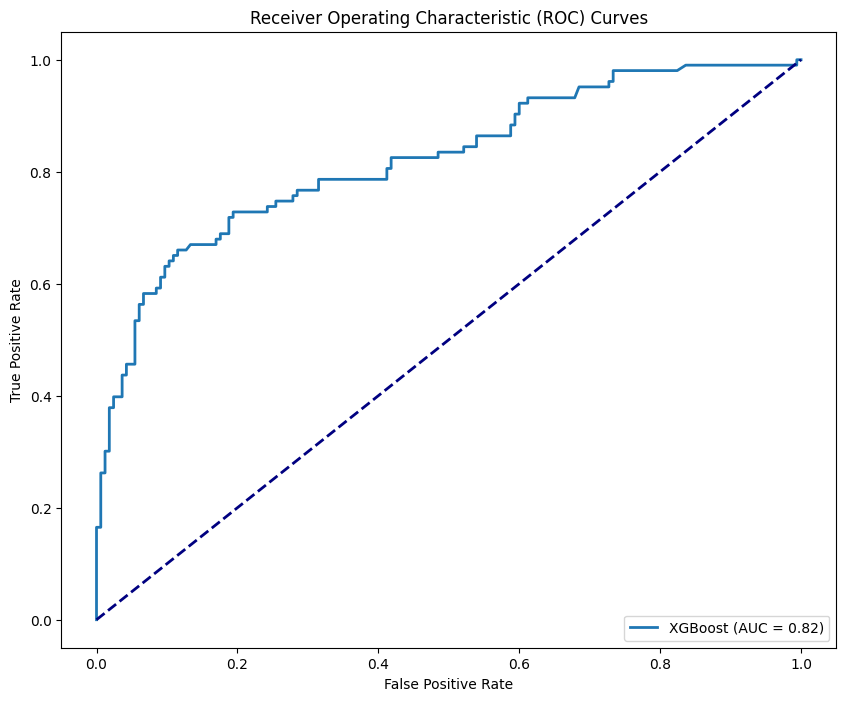

,Model,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.790000,0.760000,0.670000,0.710000


In [7]:
# Initialize models, only including XGBoost
models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Initialize a plot for combined ROC curves
plt.figure(figsize=(10, 8))

# Train and evaluate models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_test_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        roc_auc = auc(fpr, tpr)

        # Plot each model's ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random guessing in ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add plot labels and legend for ROC curve
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.show()

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Model': ['XGBoost'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
})

# Round the values to 2 decimal places and apply styling
styled_df = metrics_df.round(2).style.background_gradient(cmap="coolwarm", axis=1)

# Display the styled DataFrame
styled_df



---

# Hyperparameter Tuning and Printing Best Hyperparameters


---



A parameter grid is defined for hyperparameter tuning, which includes various values for `max_depth`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`. An XGBoost model is initialized, and `GridSearchCV` is used to search through all the combinations of hyperparameters to find the best set based on accuracy. The grid search is performed with cross-validation (`cv=5`), and the best hyperparameters are then printed.

In [8]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss')

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.6}




---

# Re-Train the Models with Best Parameters and Compare


---



We use Grid Search to find the best hyperparameters for the KNN and Decision Tree models, then retrain the XGBoost model using the best parameters found. After that, predictions are made for each model, and metrics like accuracy, precision, recall, and F1-score are calculated. The goal is to compare the performance of the models and determine the best one.

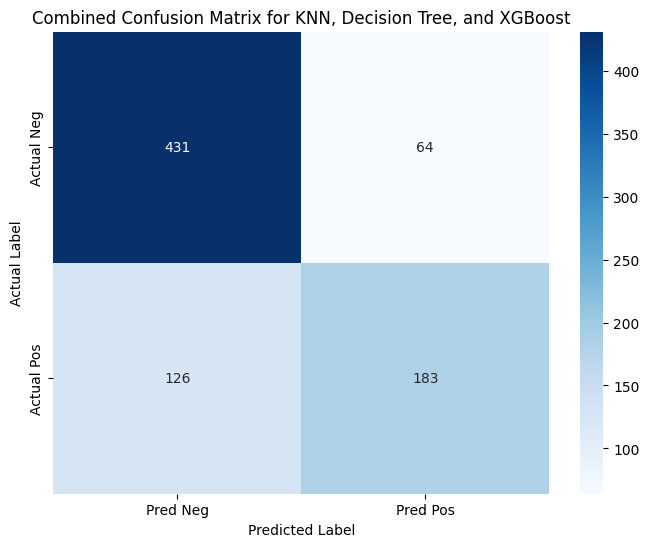

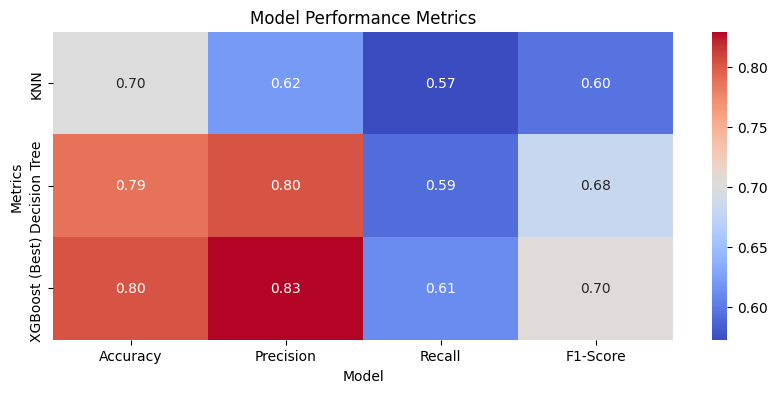

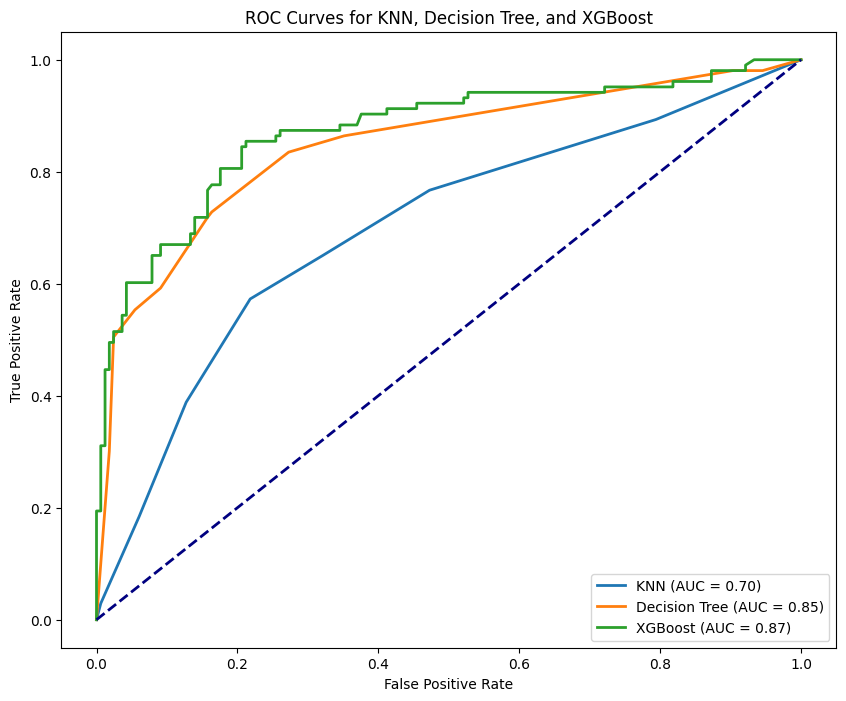

In [11]:
# Define the parameter grid for KNN and Decision Tree
knn_param_grid = {'n_neighbors': [3, 5, 7]}
tree_param_grid = {'max_depth': [3, 5, 7]}

# Initialize models
knn_model = KNeighborsClassifier()
tree_model = DecisionTreeClassifier()

# Perform Grid Search for KNN
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)
best_knn_model = knn_grid_search.best_estimator_

# Perform Grid Search for Decision Tree
tree_grid_search = GridSearchCV(tree_model, tree_param_grid, cv=5, scoring='accuracy')
tree_grid_search.fit(X_train, y_train)
best_tree_model = tree_grid_search.best_estimator_

# Remove 'random_state' if it's part of best_params
if 'random_state' in best_params:
    del best_params['random_state']

# Train XGBoost model with best parameters
best_xgb_model = XGBClassifier(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Make predictions for each model
y_test_pred_knn = best_knn_model.predict(X_test)
y_test_pred_tree = best_tree_model.predict(X_test)
y_test_pred_best = best_xgb_model.predict(X_test)

# Calculate metrics for each model
metrics = {
    'Model': ['KNN', 'Decision Tree', 'XGBoost (Best)'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred_knn),
        accuracy_score(y_test, y_test_pred_tree),
        accuracy_score(y_test, y_test_pred_best)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred_knn),
        precision_score(y_test, y_test_pred_tree),
        precision_score(y_test, y_test_pred_best)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred_knn),
        recall_score(y_test, y_test_pred_tree),
        recall_score(y_test, y_test_pred_best)
    ],
    'F1-Score': [
        f1_score(y_test, y_test_pred_knn),
        f1_score(y_test, y_test_pred_tree),
        f1_score(y_test, y_test_pred_best)
    ]
}

# Create a summary DataFrame for metrics comparison
metrics_df = pd.DataFrame(metrics)

# Display the summary DataFrame with metrics
metrics_df.set_index('Model', inplace=True)

# Create confusion matrices for each model
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
cm_tree = confusion_matrix(y_test, y_test_pred_tree)
cm_best = confusion_matrix(y_test, y_test_pred_best)

# Combine confusion matrices
combined_cm = cm_knn + cm_tree + cm_best

# Display combined confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Neg', 'Pred Pos'],
            yticklabels=['Actual Neg', 'Actual Pos'])
plt.title('Combined Confusion Matrix for KNN, Decision Tree, and XGBoost')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Display metrics DataFrame as a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(metrics_df, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Model Performance Metrics')
plt.ylabel('Metrics')
plt.xlabel('Model')
plt.show()

# ROC Curve for all models
plt.figure(figsize=(10, 8))

# KNN ROC
if hasattr(best_knn_model, "predict_proba"):
    y_test_prob_knn = best_knn_model.predict_proba(X_test)[:, 1]
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_test_prob_knn)
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    plt.plot(fpr_knn, tpr_knn, lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')

# Decision Tree ROC
if hasattr(best_tree_model, "predict_proba"):
    y_test_prob_tree = best_tree_model.predict_proba(X_test)[:, 1]
    fpr_tree, tpr_tree, _ = roc_curve(y_test, y_test_prob_tree)
    roc_auc_tree = auc(fpr_tree, tpr_tree)
    plt.plot(fpr_tree, tpr_tree, lw=2, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')

# XGBoost ROC
if hasattr(best_xgb_model, "predict_proba"):
    y_test_prob_best = best_xgb_model.predict_proba(X_test)[:, 1]
    fpr_best, tpr_best, _ = roc_curve(y_test, y_test_prob_best)
    roc_auc_best = auc(fpr_best, tpr_best)
    plt.plot(fpr_best, tpr_best, lw=2, label=f'XGBoost (AUC = {roc_auc_best:.2f})')

# Random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for KNN, Decision Tree, and XGBoost")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Convert data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters to reduce overfitting
best_params = {
    'max_depth': 3,               # Reduce tree depth
    'min_child_weight': 6,        # Increase minimum child weight
    'gamma': 0.2,                 # Reduce unnecessary splits
    'subsample': 0.6,             # Use 60% of the data for each tree
    'colsample_bytree': 0.6,      # Use 60% of the features for each tree
    'reg_alpha': 2,               # L1 Regularization
    'reg_lambda': 15,             # L2 Regularization
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.01,        # Smaller learning rate
    'random_state': 42
}

# Train the model with early stopping
evals = [(dtrain, 'train'), (dtest, 'test')]
xgb_model = xgb.train(
    params=best_params,            # Optimized parameters
    dtrain=dtrain,                 # Training data
    num_boost_round=2000,          # Increased boosting rounds
    evals=evals,                   # Evaluation sets
    early_stopping_rounds=30,      # Early stopping to prevent overfitting
    verbose_eval=True              # Show training logs
)

# Evaluate performance on training and test sets
y_train_pred = (xgb_model.predict(dtrain) > 0.5).astype(int)
y_test_pred = (xgb_model.predict(dtest) > 0.5).astype(int)
y_test_prob = xgb_model.predict(dtest)

# Calculate training and test accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"_"*50)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Train Precision: {train_precision:.2f}")
print(f"Train Recall: {train_recall:.2f}")
print(f"Train F1-Score: {train_f1:.2f}")

print(f"_"*50)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")


[0]	train-logloss:0.66350	test-logloss:0.66399
[1]	train-logloss:0.66125	test-logloss:0.66176
[2]	train-logloss:0.65910	test-logloss:0.65972
[3]	train-logloss:0.65834	test-logloss:0.65894
[4]	train-logloss:0.65649	test-logloss:0.65720
[5]	train-logloss:0.65474	test-logloss:0.65556
[6]	train-logloss:0.65272	test-logloss:0.65372
[7]	train-logloss:0.65055	test-logloss:0.65170
[8]	train-logloss:0.64944	test-logloss:0.65080
[9]	train-logloss:0.64743	test-logloss:0.64880
[10]	train-logloss:0.64551	test-logloss:0.64693
[11]	train-logloss:0.64343	test-logloss:0.64492
[12]	train-logloss:0.64144	test-logloss:0.64308
[13]	train-logloss:0.63963	test-logloss:0.64136
[14]	train-logloss:0.63763	test-logloss:0.63937
[15]	train-logloss:0.63598	test-logloss:0.63784
[16]	train-logloss:0.63418	test-logloss:0.63611
[17]	train-logloss:0.63346	test-logloss:0.63539
[18]	train-logloss:0.63162	test-logloss:0.63352
[19]	train-logloss:0.63063	test-logloss:0.63269
[20]	train-logloss:0.62892	test-logloss:0.63109
[2



---

# Overfitting Plot for XGBoost Bafore And After Tuning


---



Overfitting curves are plotted to show how the model performs before and after hyperparameter tuning. Overfitting occurs when the model fits the training data too closely, leading to poor performance on new (test) data. We address this issue by improving the model's hyperparameters using Grid Search, which helps make the model more general and balanced between training and test data, ultimately improving its performance on test data and reducing overfitting.


--- Before Tuning ---


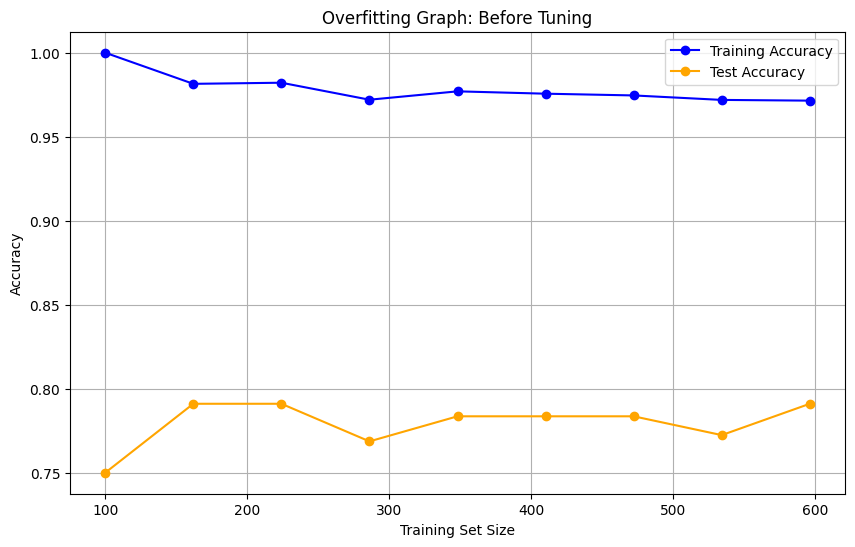


--- After Tuning ---


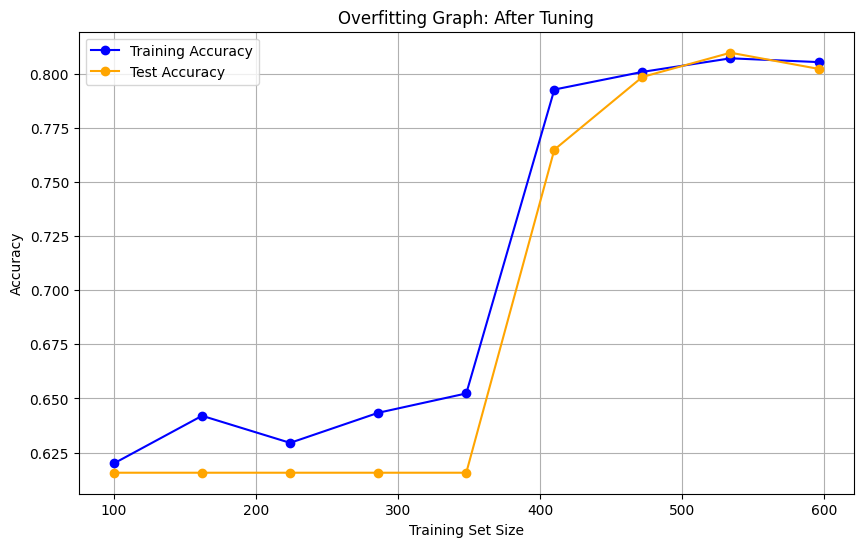

In [ ]:
# Overfitting Plot Function
def plot_overfitting_graph(model, X_train, y_train, X_test, y_test, title):
    """
    Plots overfitting graph showing training and test accuracy over increasing training set sizes.
    """
    train_accuracies = []
    test_accuracies = []
    train_sizes = list(range(100, len(X_train), max(1, len(X_train) // 10)))  # Incremental training sizes

    for size in train_sizes:
        # Train the model on a subset of the training set
        model.fit(X_train[:size], y_train[:size])

        # Calculate accuracy on the training set
        y_train_pred = model.predict(X_train[:size])
        train_acc = accuracy_score(y_train[:size], y_train_pred)
        train_accuracies.append(train_acc)

        # Calculate accuracy on the test set
        y_test_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_accuracies.append(test_acc)

    # Plot the training and test accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_accuracies, label="Training Accuracy", marker='o', color='blue')
    plt.plot(train_sizes, test_accuracies, label="Test Accuracy", marker='o', color='orange')
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Remove duplicate arguments from best_params
best_params_no_random_state = {key: value for key, value in best_params.items() if key != 'random_state'}

# Plot Overfitting Graphs
print("\n--- Before Tuning ---")
model_before_tuning = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
plot_overfitting_graph(model_before_tuning, X_train.values, y_train.values, X_test.values, y_test.values, "Overfitting Graph: Before Tuning")

print("\n--- After Tuning ---")
model_after_tuning = xgb.XGBClassifier(**best_params_no_random_state)  # Removed random_state from params
plot_overfitting_graph(model_after_tuning, X_train.values, y_train.values, X_test.values, y_test.values, "Overfitting Graph: After Tuning")



---

# Logistic Regression


---

The goal of this part of the code is to train a model using logistic regression with cost tracking during the training process.

The `sigmoid` function: Converts values into outputs between 0 and 1, used in logistic regression to predict probabilities.

The `compute_cost` function: Calculates the model's cost (how accurate the predictions are compared to the actual values) using the cost function, which depends on the variance between predictions and actual results.

The `gradient_descent_with_cost_tracking` function: Implements the gradient descent algorithm, adjusting the weights and bias to minimize the cost. Every 100 iterations, the cost value is printed to track the model's improvement.

Iteration 0: Cost = 0.6929469762974931
Iteration 100: Cost = 0.6875356501054758
Iteration 200: Cost = 0.6846789172054873
Iteration 300: Cost = 0.6827416519164122
Iteration 400: Cost = 0.6813978015852008
Iteration 500: Cost = 0.680442217397452
Iteration 600: Cost = 0.6797447983552369
Iteration 700: Cost = 0.6792222001338942
Iteration 800: Cost = 0.6788203989950369
Iteration 900: Cost = 0.6785039098062993


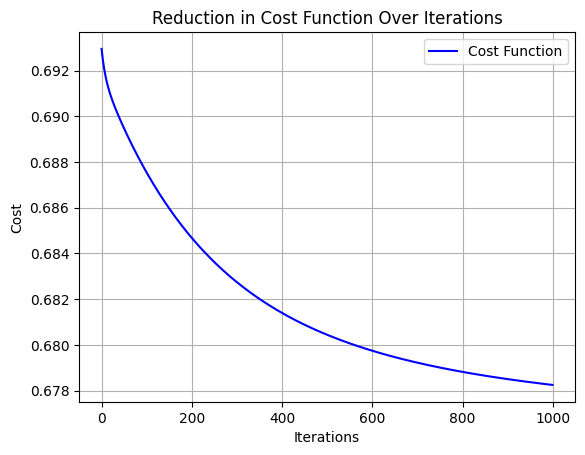

In [ ]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function
def compute_cost(X, y, w, b):
    m = X.shape[0]
    z = np.dot(X, w) + b
    predictions = sigmoid(z)
    cost = -1/m * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost

# Gradient descent with cost tracking
def gradient_descent_with_cost_tracking(X, y, w, b, learning_rate, iterations):
    m = X.shape[0]
    costs = []
    for i in range(iterations):
        z = np.dot(X, w) + b
        predictions = sigmoid(z)
        error = predictions - y
        dw = np.dot(X.T, error) / m
        db = np.sum(error) / m
        w -= learning_rate * dw
        b -= learning_rate * db
        cost = compute_cost(X, y, w, b)
        costs.append(cost)
        if i % 100 == 0:
            print(f"Iteration {i}: Cost = {cost}")
    return w, b, costs

# Plot cost reduction
def plot_cost_reduction(costs):
    plt.plot(range(len(costs)), costs, color='blue', label='Cost Function')
    plt.title('Reduction in Cost Function Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid()
    plt.show()
# Example dataset
X_train = np.random.rand(100, 5)  # Features
y_train = np.random.randint(0, 2, size=(100, 1))  # Labels

# Initialize weights and bias
w = np.zeros((X_train.shape[1], 1))
b = 0
learning_rate = 0.1
iterations = 1000

# Run gradient descent
w, b, costs = gradient_descent_with_cost_tracking(X_train, y_train, w, b, learning_rate, iterations)

# Plot cost reduction
plot_cost_reduction(costs)